In [121]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from scipy.stats import ranksums

from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.sampling.rnd import Sampling
from pymoo.operators.crossover.hux import HUX
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
from pymoo.optimize import minimize

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch

from collections import defaultdict

from joblib import Parallel, delayed
from datetime import datetime
import pandas as pd
import numpy as np
import pickle
import os

import matplotlib.pyplot as plt
import wandb

In [163]:
with open('data.pickle', 'rb') as fh:
	data_mapper = pickle.load(fh)
splits = pd.read_csv('data_splits.csv')

for split_name in splits:
	for idx in range(31):

		results = {}
		data_key = f"{idx}_{split_name}"

print(data_key)

x_train = data_mapper[data_key]['x_train'] 
y_train = data_mapper[data_key]['y_train']
x_validation = data_mapper[data_key]['x_validation'] 
y_validation = data_mapper[data_key]['y_validation']
x_test = data_mapper[data_key]['x_test'] 
y_test = data_mapper[data_key]['y_test']

minority_label = pd.DataFrame(y_train).value_counts().argmin()
minority_indices = np.where(y_train==minority_label)[0]
minority_features = x_train[minority_indices]
minority_labels = y_train[minority_indices]

30_yeast-2_vs_4


In [ ]:
class TabularDataset(Dataset):
	def __init__(self, x_synthetic, x_true):
		self.x = x_synthetic
		self.y = x_true
	def __len__(self):
		return self.x.shape[0]
	def __getitem__(self, ind):
		x = self.x[ind]
		y = self.y[ind]
		return x, y

class ConditionalVAE(nn.Module):
	def __init__(self, input_dim, label_dim, latent_dim):
		super(ConditionalVAE, self).__init__()
		hidden_dim = input_dim + input_dim // 2  # Overcomplete expansion

		# Encoder
		self.enc_fc1 = nn.Linear(input_dim + label_dim, hidden_dim)
		self.enc_fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
		self.fc_mu = nn.Linear(hidden_dim // 2, latent_dim)
		self.fc_logvar = nn.Linear(hidden_dim // 2, latent_dim)

		# Decoder
		self.dec_fc1 = nn.Linear(latent_dim + label_dim, hidden_dim // 2)
		self.dec_fc2 = nn.Linear(hidden_dim // 2, hidden_dim)
		self.dec_fc3 = nn.Linear(hidden_dim, input_dim)

	def encode(self, x, y):
		x = torch.cat([x, y], dim=1)
		h = torch.relu(self.enc_fc1(x))
		h = torch.relu(self.enc_fc2(h))
		return self.fc_mu(h), self.fc_logvar(h)

	def reparameterize(self, mu, logvar):
		std = torch.exp(0.5 * logvar)
		eps = torch.randn_like(std)
		return mu + eps * std

	def decode(self, z, y):
		z = torch.cat([z, y], dim=1)
		h = torch.relu(self.dec_fc1(z))
		h = torch.relu(self.dec_fc2(h))
		return self.dec_fc3(h)

	def forward(self, x, y):
		mu, logvar = self.encode(x, y)
		z = self.reparameterize(mu, logvar)
		return self.decode(z, y), mu, logvar

def mask_features(x, min_mask=1, max_mask=3):
	x_masked = x.clone()
	for i in range(x.size(0)):
		mask_count = torch.randint(min_mask, max_mask + 1, (1,)).item()
		mask_indices = torch.randperm(x.size(1))[:mask_count]
		x_masked[i, mask_indices] = 0
	return x_masked

def contrastive_loss(z, y, margin=1.0):
	"""
	z: (batch_size, latent_dim) latent vectors (e.g., mu)
	y: (batch_size,) class labels as integers
	"""
	# Normalize embeddings
	z_norm = nn.functional.normalize(z, p=2, dim=1)
	loss = 0.0
	count = 0
	for i in range(len(z)):
		for j in range(i + 1, len(z)):
			dist = (z_norm[i] - z_norm[j]).pow(2).sum()
			if y[i] == y[j]:
				loss += dist  # pull together
			else:
				loss += nn.functional.relu(margin - torch.sqrt(dist + 1e-8)).pow(2)  # push apart
			count += 1
	return loss / count

def weighted_contrastive_loss(z, y, margin=1.0, w_minority=5.0, w_majority=1.0):
    z_norm = nn.functional.normalize(z, p=2, dim=1)
    loss, count = 0.0, 0
    for i in range(len(z)):
      for j in range(i+1, len(z)):
        dist = (z_norm[i] - z_norm[j]).pow(2).sum()
        same = (y[i]==y[j])
        w = w_minority if y[i]==minority_label else w_majority
        if same:
          loss += w * dist
        else:
          loss += w * nn.functional.relu(margin - torch.sqrt(dist + 1e-8)).pow(2)
        count += 1
    return loss / count

def train(x, y):
	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
	cvae = ConditionalVAE(x[0].shape[0], 1, 3).to(device)

	train_set = TabularDataset(torch.from_numpy(x), torch.from_numpy(y))
	train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
	optimizer = optim.Adam(cvae.parameters(), lr=lr)

	for epoch in range(epochs):
		cvae.train()
		total_loss = 0
		for batch in train_loader:

			x_batch = batch[0].to(device).float()
			# print("----------------------------")
			# print(x_batch)
			y_batch = batch[1].to(device).float().unsqueeze(1)
			x_batch_masked = mask_features(x_batch)
			# print(x_batch_masked)
			
			recon, mu, logvar = cvae(x_batch_masked, y_batch)
			recon_loss = nn.MSELoss()(recon, x_batch)
			kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

			# cont_loss = contrastive_loss(mu, y_batch.squeeze(), margin=1.0)
			cont_loss = weighted_contrastive_loss(mu, y_batch.squeeze(), margin=1.0)

			loss = recon_loss + beta * kl_div + alpha * cont_loss
		
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()
			
			total_loss += loss.item()
		if epoch % 5 == 0:
			print(f"Epoch {epoch:>3} Loss: {np.mean(total_loss)}")

	return cvae

def generate_latents(cvae, x, y):
	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
	cvae.eval()
	
	with torch.no_grad():    
		x = torch.from_numpy(x).to(device).float()
		y = torch.from_numpy(y).to(device).float().unsqueeze(1)
		mu, logvar = cvae.encode(x, y)
		z = cvae.reparameterize(mu, logvar)
		minority_latents = z.cpu().numpy()

	return minority_latents

In [ ]:
x = np.concatenate((x_train, x_validation), axis=0)
y = np.concatenate((y_train, y_validation), axis=0)

offset_x_train = np.add(x, 30)
np.max(offset_x_train, axis=0), np.min(offset_x_train, axis=0)

epochs = 900
batch_size = 32
lr = 1e-3
beta = 0.9
alpha = 0.2

cvae = train(offset_x_train, y)


Epoch   0 Loss: 18279.93670654297
Epoch   5 Loss: 11624.263122558594
Epoch  10 Loss: 11008.886535644531
Epoch  15 Loss: 9280.2763671875
Epoch  20 Loss: 3557.2414321899414
Epoch  25 Loss: 2296.850845336914
Epoch  30 Loss: 2115.538558959961
Epoch  35 Loss: 1494.3841552734375
Epoch  40 Loss: 1215.116828918457
Epoch  45 Loss: 1096.6934547424316
Epoch  50 Loss: 848.529091835022
Epoch  55 Loss: 835.8937339782715
Epoch  60 Loss: 707.210563659668
Epoch  65 Loss: 655.6331920623779
Epoch  70 Loss: 608.1940274238586
Epoch  75 Loss: 584.4326210021973
Epoch  80 Loss: 533.19020652771
Epoch  85 Loss: 457.6686611175537
Epoch  90 Loss: 440.99091148376465
Epoch  95 Loss: 393.51414585113525
Epoch 100 Loss: 341.13244915008545
Epoch 105 Loss: 264.24204981327057
Epoch 110 Loss: 175.12461185455322
Epoch 115 Loss: 138.9082372188568
Epoch 120 Loss: 90.51060056686401
Epoch 125 Loss: 71.70819759368896
Epoch 130 Loss: 64.0094404220581
Epoch 135 Loss: 57.49232196807861
Epoch 140 Loss: 54.48973172903061
Epoch 145 L

KeyboardInterrupt: 

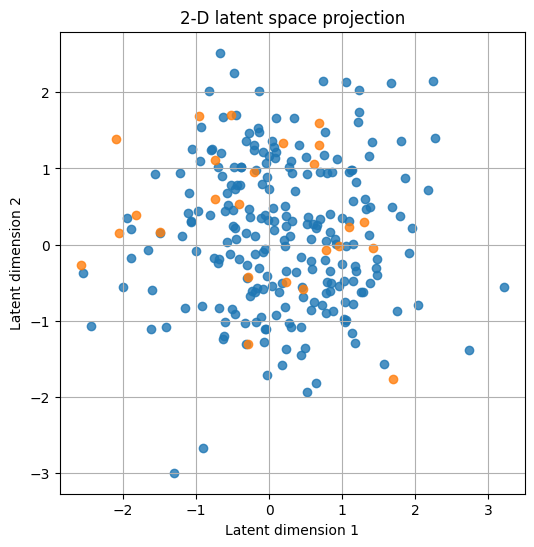

In [185]:
plot_x = x_train
plot_y = y_train

latents = generate_latents(cvae, plot_x, plot_y)

fig, ax = plt.subplots(figsize=(6, 6))     # one figure, no sub-plots
for lab in np.unique(plot_y):                 # ➊ iterate once per class
	idx = plot_y == lab                       # ➋ boolean mask
	ax.scatter(latents[idx, 0], latents[idx, 1], label=f"Class {lab}", alpha=0.8) 
	ax.set_xlabel("Latent dimension 1")        # always label axes
ax.set_ylabel("Latent dimension 2")
ax.set_title("2-D latent space projection")
ax.grid(True)                              # optional helper grid
plt.show()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cvae.eval()

with torch.no_grad():    
    x_temp = torch.from_numpy(x).to(device).float()
    y_temp = torch.from_numpy(y).to(device).float().unsqueeze(1)
    recon, mu, logvar = cvae(x_temp, y_temp)
    # z = cvae.reparameterize(mu, logvar)
    # minority_latents = z.cpu().numpy()
over_sample_x = recon.cpu().numpy()
over_sample_labels = y

model = KNeighborsClassifier(n_neighbors=5)
model.fit(over_sample_x, over_sample_labels)
y_pred = model.predict(x_test)
roc_auc_score(y_test, y_pred)

# offset_x_train = np.add(x, -30)

np.float64(0.5)

: 